In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

from prio_first import schedule_rules
from find_next_slot import schedule_rules_with_slots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_link_schedule(rules, bandwidth, reservations, results):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    max_time = 0
    if reservations:
        max_time = max(max_time, max(end for _, end, _ in reservations))
    if results:
        max_time = max(max_time, max(end for _, _, end, _ in results))
    max_time = max(max_time, 20)  # Minimum time range
    
    link_rect = patches.Rectangle((0, 0), max_time, bandwidth, 
                                linewidth=2, edgecolor='black', 
                                facecolor='lightgray', alpha=0.3)
    ax.add_patch(link_rect)
    
    for start_time, end_time, reserved_bw in reservations:
        reservation_rect = patches.Rectangle((start_time, 0), end_time - start_time, reserved_bw,
                                           linewidth=1, edgecolor='darkred', 
                                           facecolor='red', alpha=0.7)
        ax.add_patch(reservation_rect)
        
        # Add reservation label
        ax.text(start_time + (end_time - start_time)/2, reserved_bw/2, 
               f'Reserved\n{reserved_bw} bw', 
               ha='center', va='center', fontsize=8, color='white', weight='bold')
    
    y_offset = 0
    
    for i, (rule_idx, start_time, end_time, allocated_bw) in enumerate(results):
        size, priority = rules[rule_idx]
        color = 'blue'
        
        # Find the y position (stack rules vertically)
        y_pos = sum(res_bw for s, e, res_bw in reservations if s <= start_time < e)
        y_pos += y_offset
        
        rule_rect = patches.Rectangle((start_time, y_pos), end_time - start_time, allocated_bw,
                                        linewidth=1, edgecolor='darkblue', 
                                        facecolor=color, alpha=0.7)
        ax.add_patch(rule_rect)
        
        # Add rule label
        label = f'R{rule_idx}\nSize: {size}\nPrio: {priority}\nBW: {allocated_bw:.1f}'
        ax.text(start_time + (end_time - start_time)/2, y_pos + allocated_bw/2, 
               label, ha='center', va='center', fontsize=8, color='white', weight='bold')
        
        y_offset += allocated_bw
    
    ax.set_xlim(0, max_time)
    ax.set_ylim(0, bandwidth)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Bandwidth', fontsize=12)
    ax.set_title('Link Schedule Visualization', fontsize=14, weight='bold')
    ax.grid(True, alpha=0.3)
    
    red_patch = patches.Patch(color='red', alpha=0.7, label='Reservations')
    blue_patch = patches.Patch(color='blue', alpha=0.7, label='Scheduled Rules')
    ax.legend(handles=[red_patch, blue_patch], loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [3]:
# rule: (size, priority)
rules=[(200, 5), (100, 2), (500, 1)]
bandwidth=100
reservations=[(10, 13, 50), (15, 30, 75)]

In [4]:
USE_PRIO_FIRST = True

Scheduled rules:
rule 0: time 0.00-2.00, bandwidth 100.0


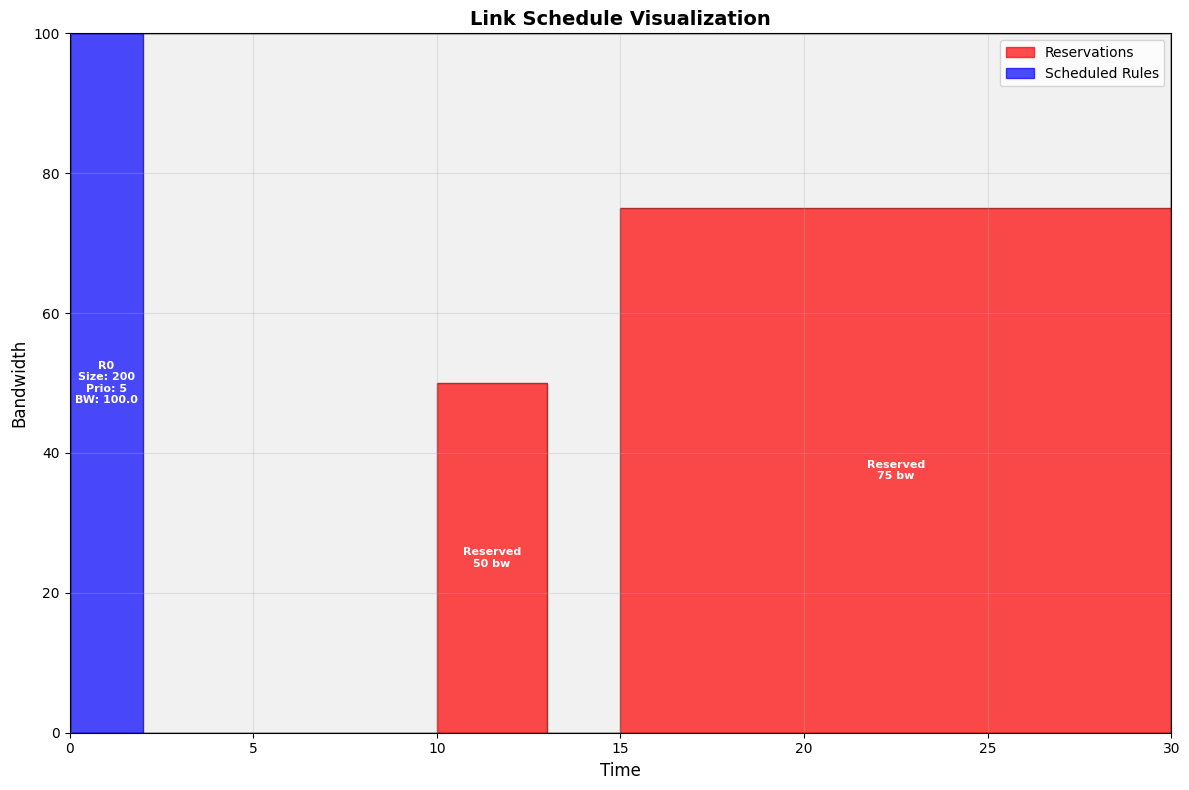

In [5]:
if USE_PRIO_FIRST:
    results = schedule_rules(rules, bandwidth, reservations)
else:
    results = schedule_rules_with_slots(rules, bandwidth, reservations)

print("Scheduled rules:")
for result in results:
    print(f"rule {result[0]}: time {result[1]:.2f}-{result[2]:.2f}, bandwidth {result[3]:.1f}")

visualize_link_schedule(rules, bandwidth, reservations, results)

In [6]:
from find_least_waste import (
    get_next_slot, compute_slot_areas, r_sorted_by_area,
    find_r_slot_with_allocation, visualize_integrated_schedule
)

def run_find_least_waste(unavailable_slots, total_slots, request_r):
    slot_rects = get_next_slot(unavailable_slots, total_slots)
    slot_areas = compute_slot_areas(slot_rects)
    request_areas = r_sorted_by_area(request_r)

    for area, rid in request_areas:
        size, priority = request_r[rid-1]

    result_texts, allocations, waste_rects, total_available_area, total_r_area = find_r_slot_with_allocation(
        request_areas, slot_areas, slot_rects, unavailable_slots, request_r
    )
    print("Final allocation details:")
    for x1, x2, y1, y2, rid in allocations:
        size, priority = request_r[rid-1]
        print(f"  R{rid}: time [{x1:.1f}, {x2:.1f}], bandwidth [{y1:.2f}, {y2:.2f}]")
        print(f"       size={size}, priority={priority}, actual_area={(x2-x1)*(y2-y1):.1f}")
    print()

    if total_available_area < total_r_area:
        print(f"Need to extend space (shortage: {total_r_area - total_available_area})")
    else:
        print("All requests can be accommodated")

    visualize_integrated_schedule(request_r, unavailable_slots, total_slots, allocations, waste_rects)


In [7]:
unavailable_slots = {(5, 15, 40), (20, 25, 60)}  # Reserved bandwidth
total_slots = {(0, 30, 100)}  # Total available space
request_r = [(400, 3), (300, 5), (200, 2), (150, 1)]  # Requests (size, priority)

Final allocation details:
  R3: time [0.0, 5.0], bandwidth [0.00, 40.00]
       size=200, priority=2, actual_area=200.0
  R4: time [0.0, 20.0], bandwidth [40.00, 46.67]
       size=150, priority=1, actual_area=133.3
  R2: time [0.0, 8.0], bandwidth [46.67, 80.00]
       size=300, priority=5, actual_area=266.7
  R1: time [0.0, 17.8], bandwidth [80.00, 100.00]
       size=400, priority=3, actual_area=355.6

All requests can be accommodated


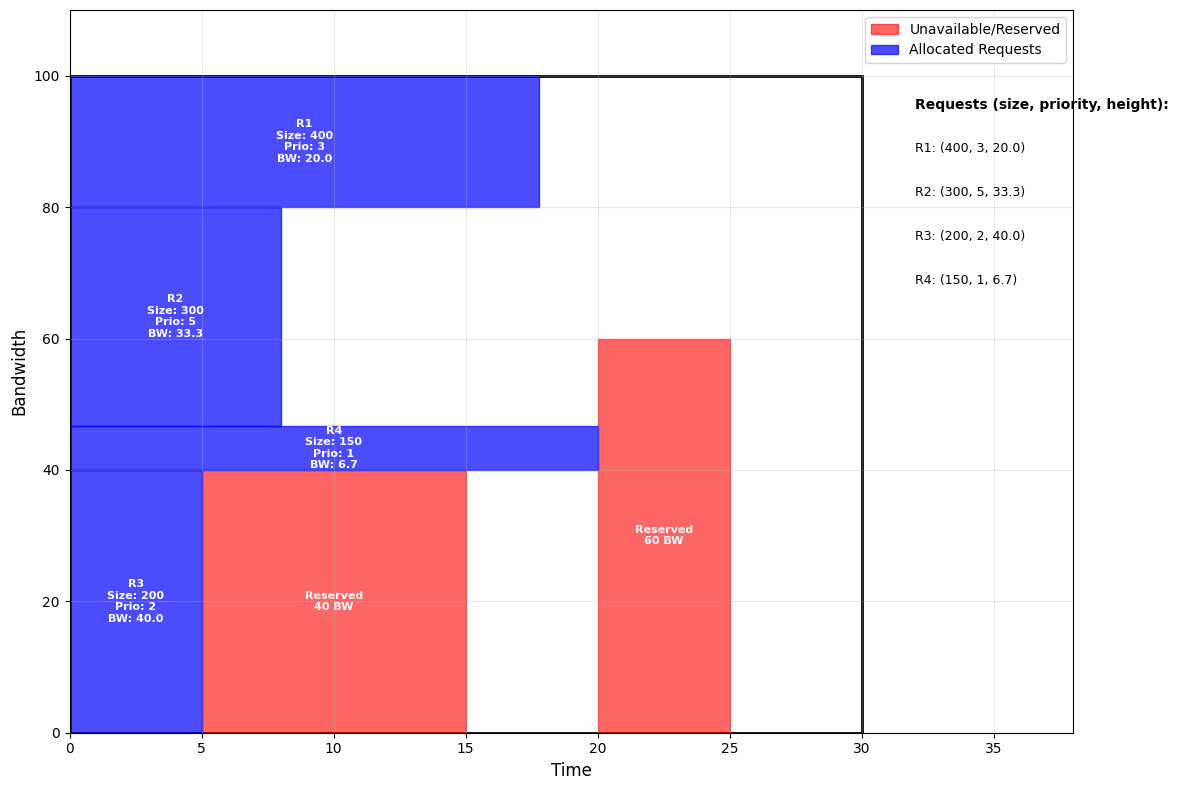

In [8]:
run_find_least_waste(unavailable_slots, total_slots, request_r)